#Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.data.experimental import AUTOTUNE

#Data Exploration and Visualization

In [2]:
def plot_sample_images(dataset, num_samples=5):
    dataset_iter = iter(dataset)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        image, label = next(dataset_iter)
        image = image.numpy()

        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


In [3]:
ds_train, ds_info = tfds.load("imagenette/320px-v2", split="train", as_supervised=True, with_info=True)
ds_train_sample = ds_train.take(5)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/320px-v2/incomplete.NJBGQ9_1.0.0/imagenette-train.tfrecord*...:…

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/320px-v2/incomplete.NJBGQ9_1.0.0/imagenette-validation.tfrecord…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/320px-v2/1.0.0. Subsequent calls will reuse this data.


In [4]:
ds_val = tfds.load('imagenette/320px-v2', split='validation', as_supervised=True)
ds_val_sample = ds_val.take(5)

In [5]:
num_classes = ds_info.features['label'].num_classes
print(f"Number of classes: {num_classes}")

Number of classes: 10


In [6]:
for image, label in ds_train.take(1):
    print("Image shape:", image.shape)

Image shape: (320, 396, 3)


In [7]:
def center_crop(img, crop_size=320):
    ''' This function crops lr(64x64) and hr(256x256) images at the center'''
    img_shape = tf.shape(img)[:2]

    x = (img_shape[1] - crop_size) // 2
    y = (img_shape[0] - crop_size) // 2

    img_cropped = img[y:y + crop_size, x:x + crop_size]

    return img_cropped

def preprocess_image(image, label, crop_size=320):
    image = tf.image.resize(image, [crop_size, crop_size])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [8]:
ds_train_preprocessed = ds_train.map(lambda img, lbl: preprocess_image(img, lbl, crop_size=320))
ds_valid_preprocessed = ds_val.map(lambda img, lbl: preprocess_image(img, lbl, crop_size=320))

In [9]:
for image, label in ds_train_preprocessed.take(5):
    print("Preprocessed image shape:", image.shape)

Preprocessed image shape: (320, 320, 3)
Preprocessed image shape: (320, 320, 3)
Preprocessed image shape: (320, 320, 3)
Preprocessed image shape: (320, 320, 3)
Preprocessed image shape: (320, 320, 3)


In [10]:
def stratified_sample(dataset, num_samples_per_class, num_classes):
    samples = [[] for _ in range(num_classes)]

    for image, label in dataset:
        label = label.numpy()
        samples[label].append((image, label))
        if all(len(samples[i]) >= num_samples_per_class for i in range(num_classes)):
            break

    samples_flat = [item for sublist in samples for item in sublist]
    # np.random.shuffle(samples_flat)

    images, labels = zip(*samples_flat)
    new_dataset = tf.data.Dataset.from_tensor_slices((list(images), list(labels)))

    return new_dataset

In [11]:
num_samples_per_class = 30
num_samples_per_class_val = 30

ds_train_stratified = stratified_sample(ds_train_preprocessed, num_samples_per_class, num_classes)
ds_valid_stratified = stratified_sample(ds_valid_preprocessed, num_samples_per_class_val, num_classes)

print(f"Length of stratified training dataset: {len(list(ds_train_stratified))}")
print(f"Length of stratified validation dataset: {len(list(ds_valid_stratified))}")

Length of stratified training dataset: 398
Length of stratified validation dataset: 357


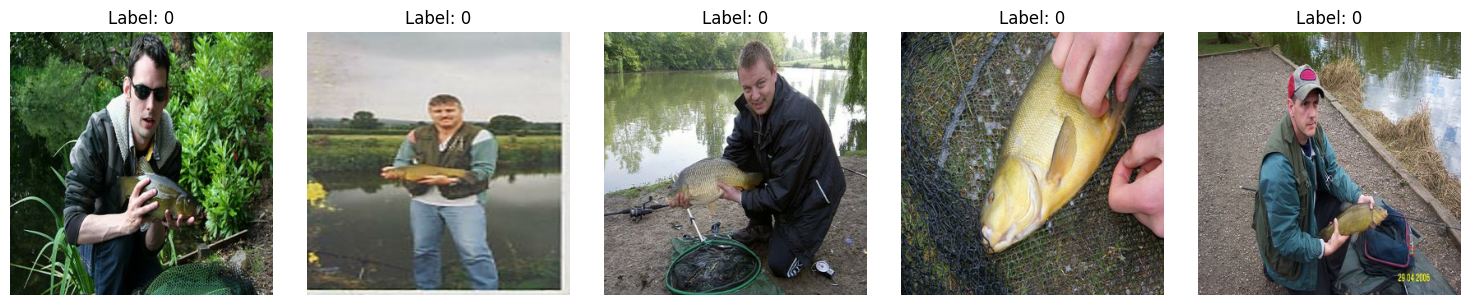

In [12]:
plot_sample_images(ds_train_stratified, num_samples=5)

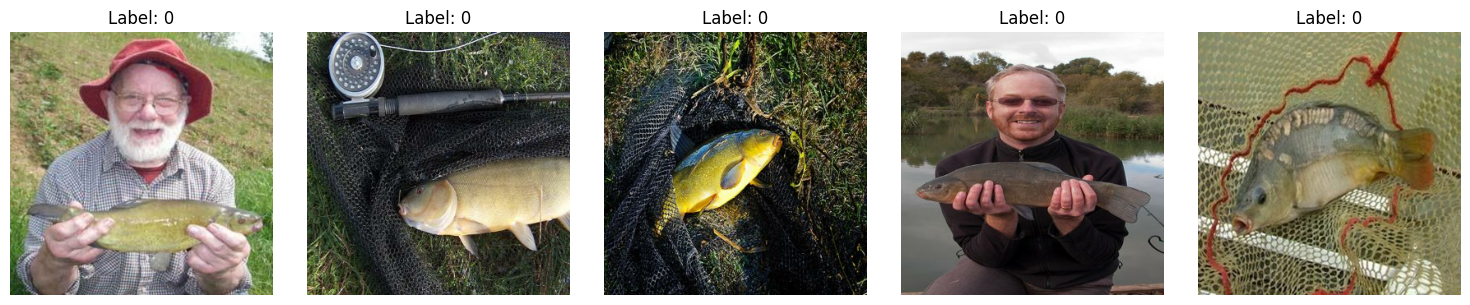

In [13]:
plot_sample_images(ds_valid_stratified, num_samples=5)

In [14]:
def get_dataset_length(dataset):
    return sum(1 for _ in dataset)

In [15]:
length = get_dataset_length(ds_train_stratified)
print(f"The length of the ds_train_stratified dataset is: {length}")
lengthval = get_dataset_length(ds_valid_stratified)
print(f"The length of the ds_valid_stratified dataset is: {lengthval}")

The length of the ds_train_stratified dataset is: 398
The length of the ds_valid_stratified dataset is: 357


#Downscaling

In [16]:
def plot_ds_images(dataset, num_samples=5):
    # Get an iterator over the dataset
    dataset_iter = iter(dataset)

    # Plot sample images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    fig.suptitle("Downscaled Bicubic")
    for i in range(num_samples):
        # Get the next image and label from the dataset
        image, label = next(dataset_iter)
        image = image.numpy()  # Convert TensorFlow tensor to NumPy array

        # Plot the image
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

##DPID

In [17]:
dpid_downscaled_img = []
ori_img_dpid = []
labels = []
dpid_downscaled_img_val = []
ori_img_dpid_val = []
labels_val = []
count = 0
count2 = 0
scale_factor = 0.2
n_data = length
n_dataval = lengthval

In [19]:
def dpid_downscale(image):
  src = image
  [iHeight, iWidth, channels]= src.shape
  oWidth=64
  oHeight=64
  _lambda=1.0
  avgImage = np.zeros([oHeight, oWidth, channels])
  oImage   = np.zeros([oHeight, oWidth, channels])
  pWidth  = iWidth  / oWidth
  pHeight = iHeight / oHeight
  for py in range(oHeight):
      for px in range(oWidth):
          sx = max(px * pWidth, 0)
          ex = min((px+1) * pWidth, iWidth)
          sy = max(py * pHeight, 0)
          ey = min((py+1) * pHeight, iHeight)

          sxr = math.floor(sx)
          syr = math.floor(sy)
          exr = math.ceil(ex)
          eyr = math.ceil(ey)

          avgF = 0

          for iy in range(syr,eyr):
              for ix in range(sxr,exr):
                  f=1
                  if(ix < sx):
                      f = f * (1.0 - (sx - ix))
                  if((ix+1) > ex):
                      f = f * (1.0 - ((ix+1) - ex))
                  if(iy < sy):
                      f = f * (1.0 - (sy - iy))
                  if((iy+1) > ey):
                      f = f * (1.0 - ((iy+1) - ey))
                  avgImage[py, px, :] = avgImage[py, px, :] + (src[iy, ix, :] * f)
                  avgF = avgF + f
          avgImage[py, px, :] = avgImage[py, px, :] / avgF
  for py in range(oHeight):
      for px in range(oWidth):
          avg=np.zeros([1, channels + 1])
          if(py > 0):
              if(px > 0):
                  avg = avg + np.append(np.reshape(avgImage[py-1, px-1,   :], [1,channels]) * 1,1)
              avg = avg + np.append(np.reshape(avgImage[py-1, px+0, :], [1,channels]) * 2,2)
              if((px+1) < oWidth):
                  avg = avg + np.append(np.reshape(avgImage[py-1, px+1, :], [1,channels]) * 1,1)
          if(px > 0):
              avg = avg + np.append(np.reshape(avgImage[py+0, px-1,   :], [1,channels]) * 2,2)
          avg = avg + np.append(np.reshape(avgImage[py+0, px+0, :], [1,channels]) * 4,4)
          if((px+1) < oWidth):
              avg = avg + np.append(np.reshape(avgImage[py+0, px+1, :], [1,channels]) * 2,2)

          if((py+1) < oHeight):
              if(px > 0):
                  avg = avg + np.append(np.reshape(avgImage[py+1, px-1,   :], [1,channels]) * 1,1)
              avg = avg + np.append(np.reshape(avgImage[py+1, px+0, :], [1,channels]) * 2,2)
              if((px+1) < oWidth):
                  avg = avg + np.append(np.reshape(avgImage[py+1, px+1, :], [1,channels]) * 1,1)
          if avg[0][3]==4:
              print(avg[0][3])
          avg = avg / avg[0][3]
          avg = avg[0][0:channels]
          sx = max(px * pWidth, 0)
          ex = min((px+1) * pWidth, iWidth)
          sy = max(py * pHeight, 0)
          ey = min((py+1) * pHeight, iHeight)

          sxr = math.floor(sx)
          syr = math.floor(sy)
          exr = math.ceil(ex)
          eyr = math.ceil(ey)

          oF = 0

          for iy in range(syr,(eyr)):
              for ix in range(sxr,(exr)):
                  if _lambda == 0:
                      f = 1
                  else:
                      f=np.linalg.norm(avg - np.reshape(src[iy + 0, ix + 0, :], [1,channels]),2)
                      #f=f/441.6729559
                      f = f **_lambda

                  if(ix < sx):
                      f = f * (1.0 - (sx - ix))
                  if((ix+1) > ex):
                      f = f * (1.0 - ((ix+1) - ex))
                  if(iy < sy):
                      f = f * (1.0 - (sy - iy))
                  if((iy+1) > ey):
                      f = f * (1.0 - ((iy+1) - ey))

                  oImage[py + 0, px + 0, :] = oImage[py + 0, px + 0, :] + (src[iy + 0, ix + 0, :] * f)
                  oF = oF + f

          if (oF == 0):
              oImage[py + 0, px + 0, :] = avg
          else:
              oImage[py + 0, px + 0, :] = oImage[py + 0, px + 0, :] / oF
  oImage /= 255.0
  return oImage

In [20]:
print("Train")
count = 0
for image, label in ds_train_stratified.take(n_data).as_numpy_iterator():
    count += 1
    if count % 100 == 0:
        print(f"Processed {count} images")
    downscaled_image = dpid_downscale(image)
    dpid_downscaled_img.append(downscaled_image)
    ori_img_dpid.append(image)
    labels.append(label)

dpid_downscaled_img = np.array(dpid_downscaled_img)
ori_img_dpid = np.array(ori_img_dpid)
labels = np.array(labels)

print("Processing complete.")

Train
Processed 100 images
Processed 200 images
Processed 300 images
Processing complete.


In [ ]:
print("Valid")
for image, label in ds_valid_stratified.take(n_dataval).as_numpy_iterator():
  count2 += 1
  if count2 % 100 == 0:
      print(f"Processed {count2} images")
  downscaled_image = dpid_downscale(image)
  dpid_downscaled_img_val.append(downscaled_image)
  ori_img_dpid_val.append(image)
  labels_val.append(label)

dpid_downscaled_img_val = np.array(dpid_downscaled_img_val)
ori_img_dpid_val = np.array(ori_img_dpid_val)
labels_val = np.array(labels_val)

In [ ]:
print("Shape of downscaled images array:", dpid_downscaled_img.shape)
print("Shape of downscaled images array:", dpid_downscaled_img_val.shape)

In [21]:
def plot_images(original_images, downscaled_images, num_images=5):
    plt.figure(figsize=(10, 4 * num_images))
    for i in range(num_images):
        # Plot original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(original_images[i])
        plt.title("Original Image")
        plt.axis("off")

        # Plot downscaled image
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(downscaled_images[i])
        plt.title("Downscaled Image")
        plt.axis("off")
    plt.show()

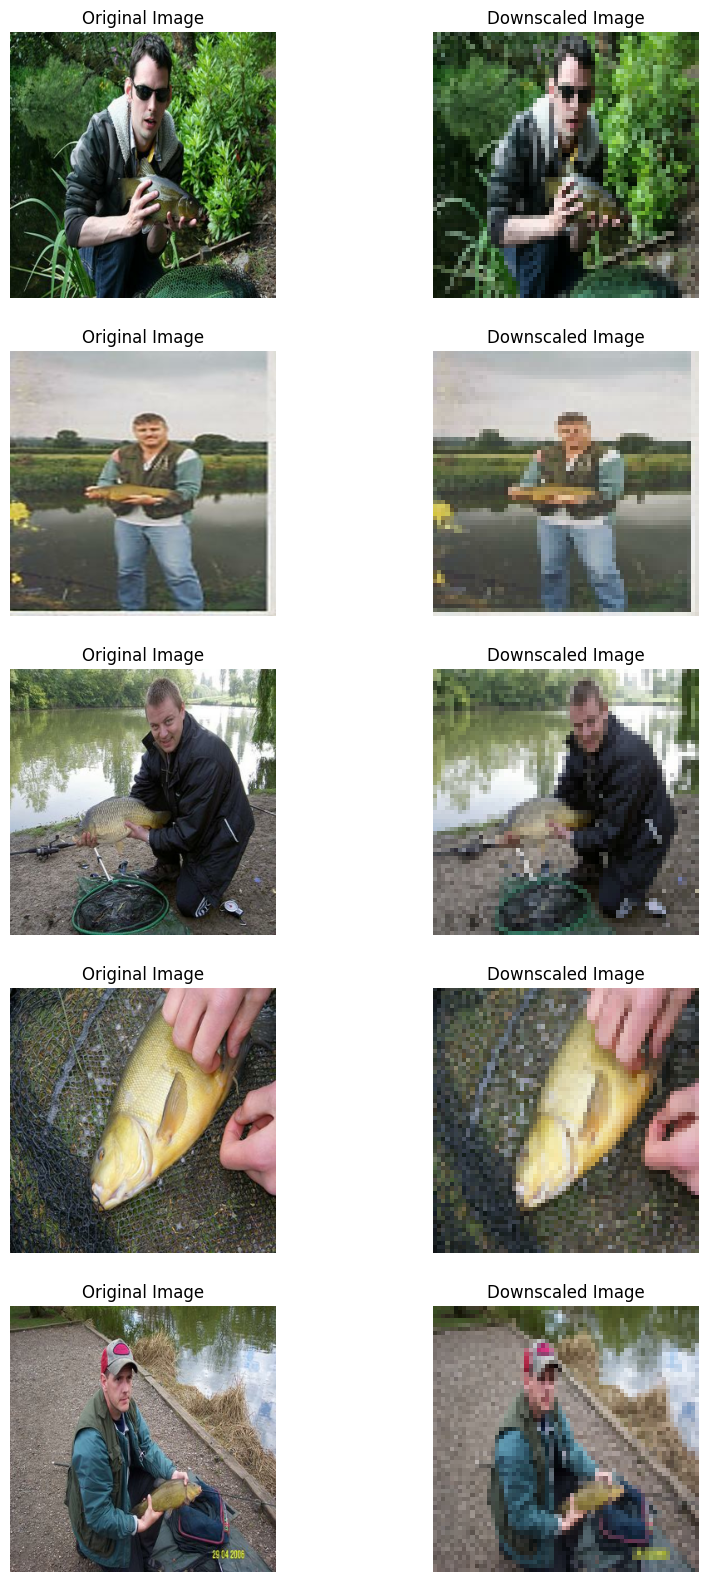

In [23]:
plot_images(ori_img_dpid, dpid_downscaled_img*255, num_images=5)

#Analysis

In [24]:
from skimage.measure import shannon_entropy
from sklearn.cluster import KMeans
import seaborn as sns
from skimage import color

In [25]:
ori_img_dpid_sample = ori_img_dpid[0]
dpid_downscaled_img_sample = dpid_downscaled_img[0]
print(ori_img_dpid_sample.shape)
print(dpid_downscaled_img_sample.shape)

(320, 320, 3)
(64, 64, 3)


In [26]:
# Compute Entropy
original_entropy = shannon_entropy(ori_img_dpid_sample)
downscaled_entropy = shannon_entropy(dpid_downscaled_img_sample*255)
print(f'Original Entropy: {original_entropy}')
print(f'Downscaled Entropy: {downscaled_entropy}')

Original Entropy: 9.44301486447183
Downscaled Entropy: 13.581298800362381


In [27]:
def plot_color_histograms(original, downscaled):
    color = ('r', 'g', 'b')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Color Histograms')

    ax1.set_title('Original')
    for i, col in enumerate(color):
        orig_hist = cv2.calcHist([np.uint8(original * 255)], [i], None, [256], [0, 256])
        ax1.plot(orig_hist, color=col)
    ax1.set_xlabel('Pixel Value')
    ax1.set_ylabel('Frequency')

    ax2.set_title('Downscaled')
    for i, col in enumerate(color):
        down_hist = cv2.calcHist([np.uint8(downscaled * 255)], [i], None, [256], [0, 256])
        ax2.plot(down_hist, color=col)
    ax2.set_xlabel('Pixel Value')
    ax2.set_ylabel('Frequency')

    plt.show()

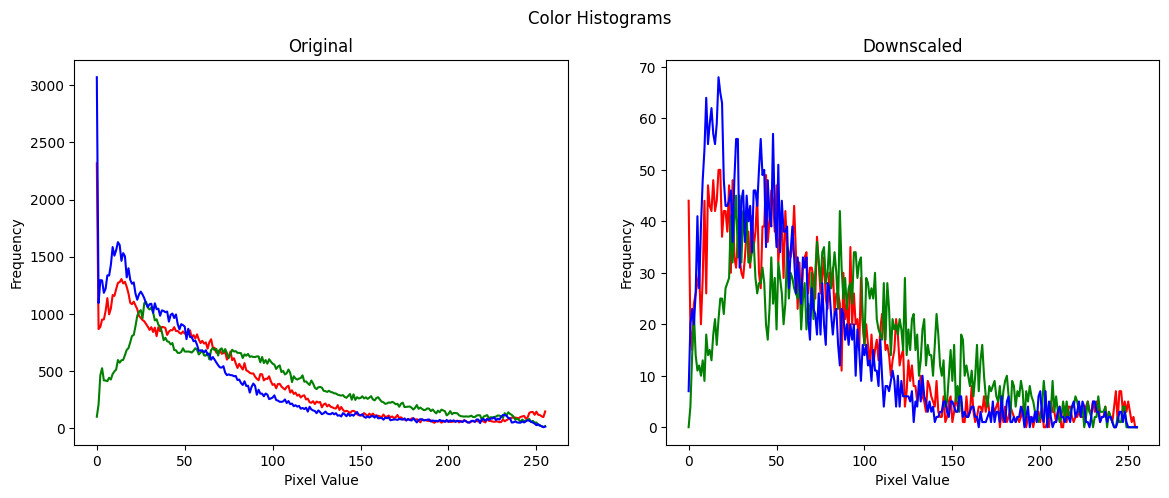

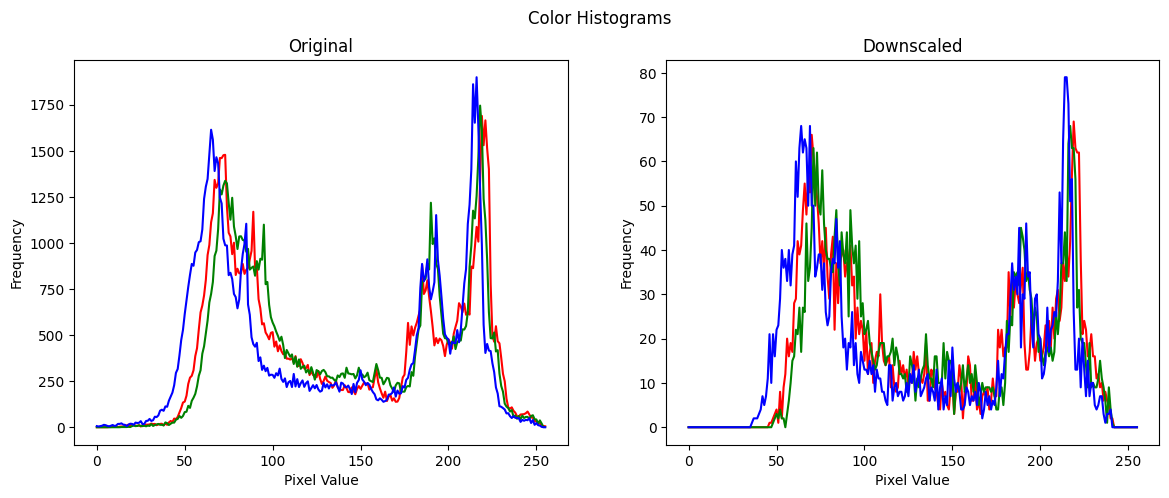

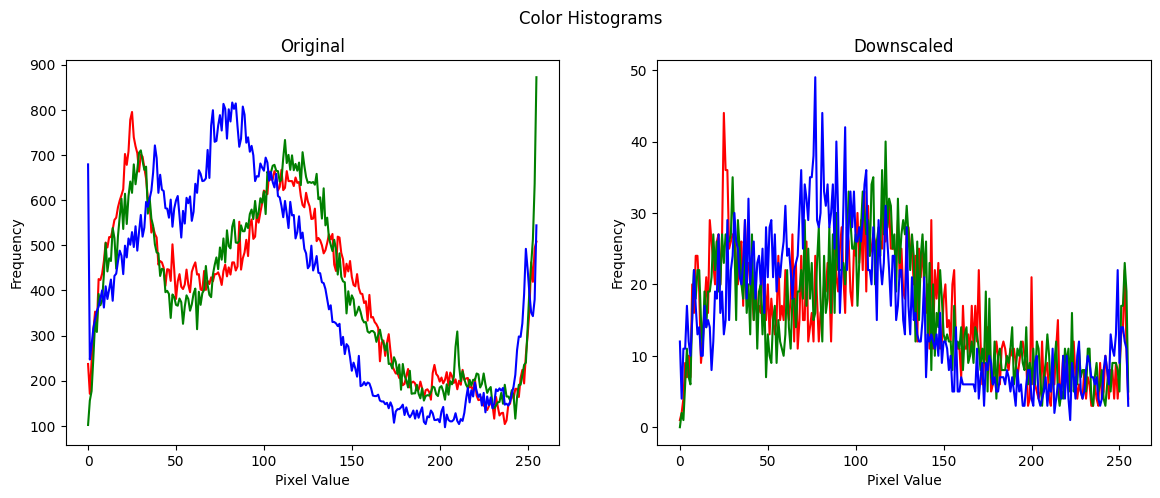

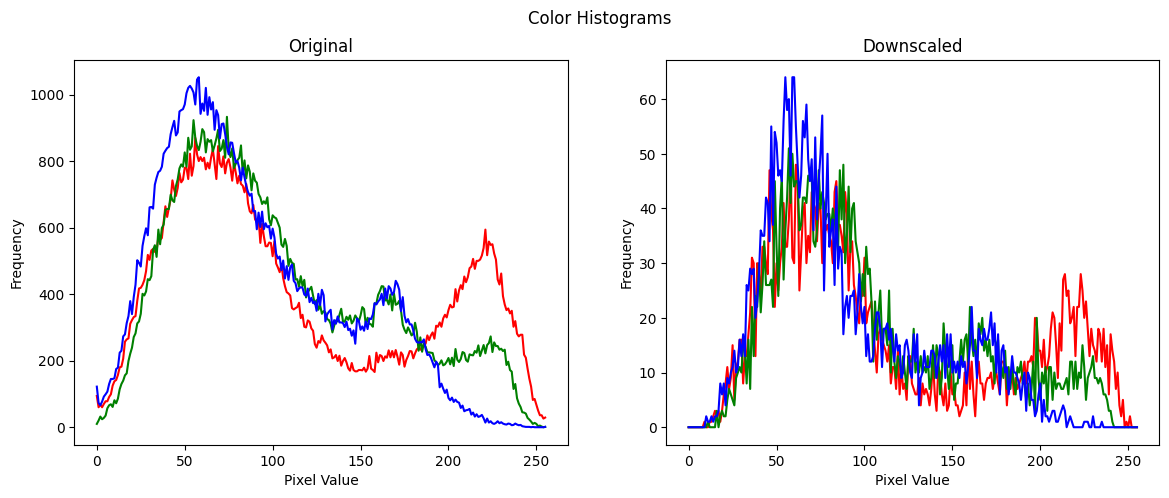

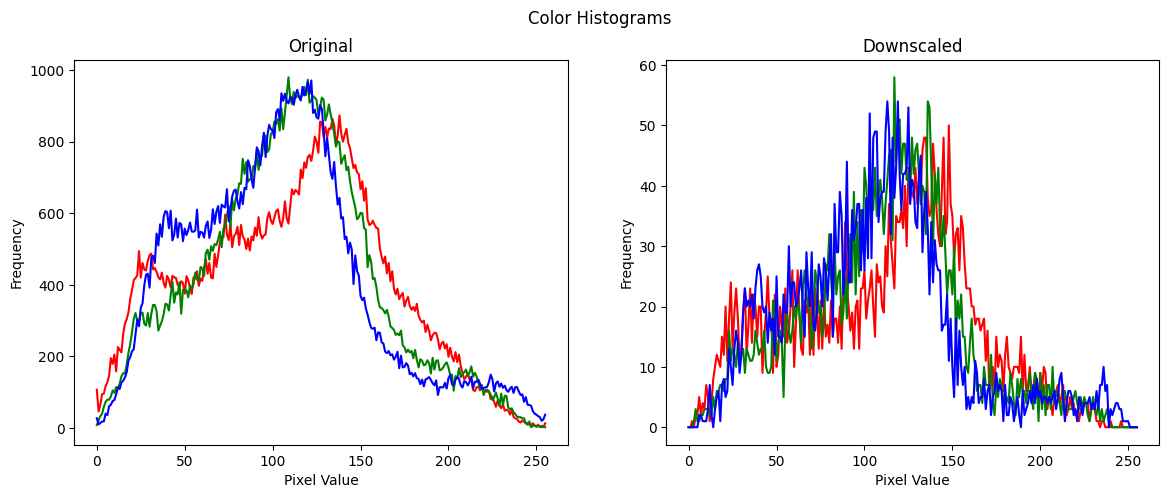

In [28]:
for i in range(5):  # Plot histograms for 5 samples
    plot_color_histograms(ori_img_dpid[i], dpid_downscaled_img[i]*255)

In [29]:
def get_dominant_colors(image, k=5):
    pixels = np.float32(image.reshape(-1, 3))
    _, labels, palette = cv2.kmeans(pixels, k, None,
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                                    10, cv2.KMEANS_RANDOM_CENTERS)
    _, counts = np.unique(labels, return_counts=True)
    dominant_colors = palette[np.argsort(-counts)]
    return dominant_colors.astype(int), counts

def plot_dominant_colors(dominant_colors, counts):
    plt.figure(figsize=(8, 4))
    plt.pie(counts, labels=[f'#{r:02x}{g:02x}{b:02x}' for r, g, b in dominant_colors],
            colors=[(r/255, g/255, b/255) for r, g, b in dominant_colors], startangle=90)
    plt.axis('equal')
    plt.title('Dominant Colors')
    plt.show()

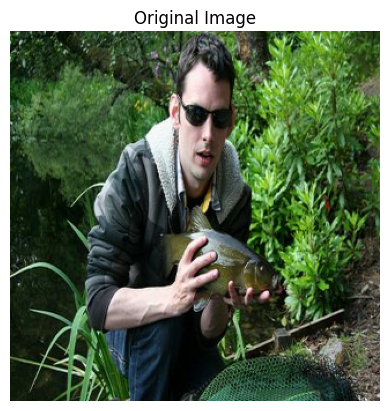

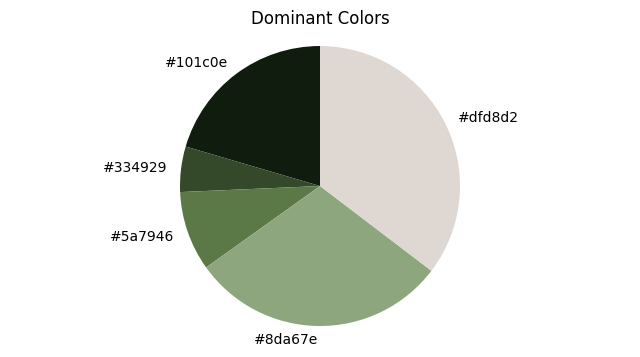

Color: #101c0e, Percentage: 20.45%
Color: #334929, Percentage: 5.24%
Color: #5a7946, Percentage: 9.19%
Color: #8da67e, Percentage: 29.77%
Color: #dfd8d2, Percentage: 35.35%


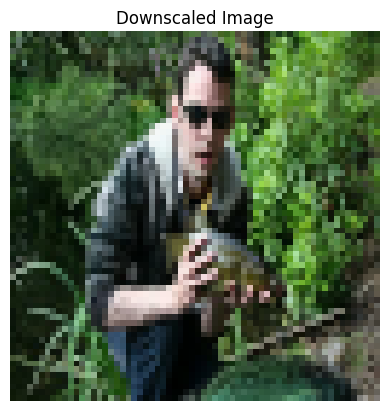

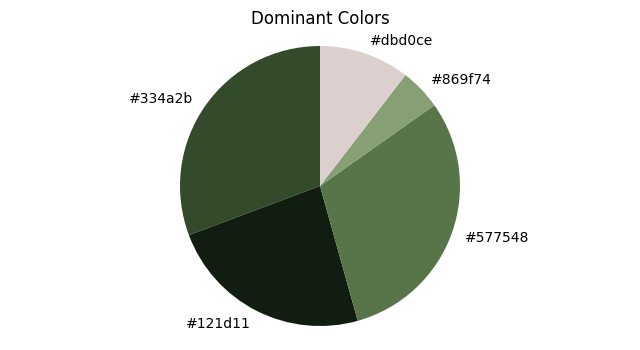

Color: #334a2b, Percentage: 30.71%
Color: #121d11, Percentage: 23.63%
Color: #577548, Percentage: 30.44%
Color: #869f74, Percentage: 4.76%
Color: #dbd0ce, Percentage: 10.45%


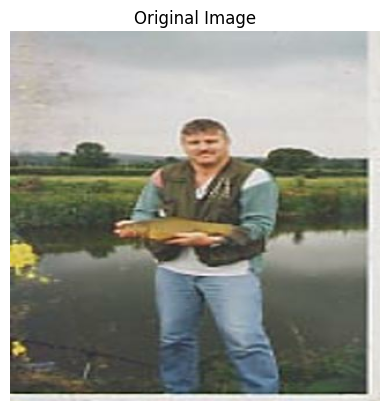

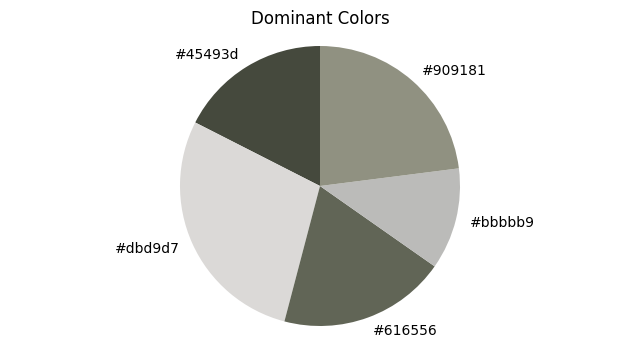

Color: #45493d, Percentage: 17.51%
Color: #dbd9d7, Percentage: 28.40%
Color: #616556, Percentage: 19.36%
Color: #bbbbb9, Percentage: 11.75%
Color: #909181, Percentage: 22.99%


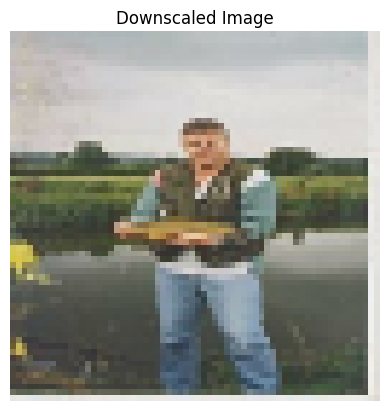

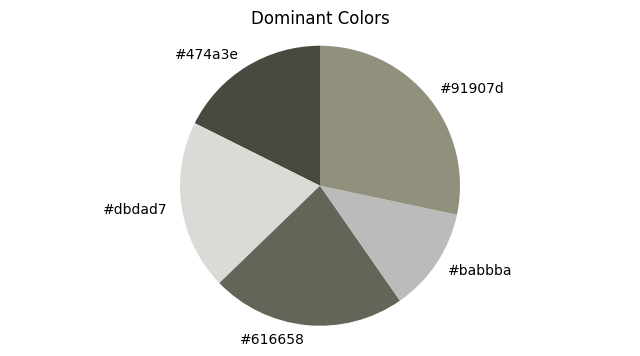

Color: #474a3e, Percentage: 17.63%
Color: #dbdad7, Percentage: 19.60%
Color: #616658, Percentage: 22.44%
Color: #babbba, Percentage: 12.01%
Color: #91907d, Percentage: 28.32%


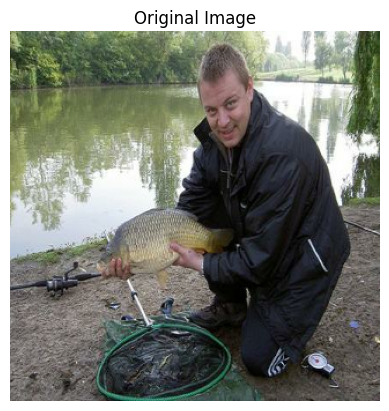

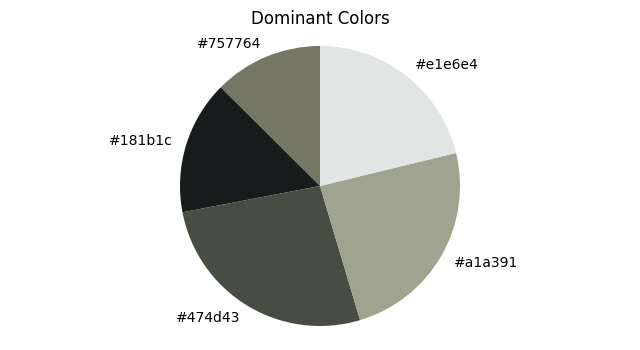

Color: #757764, Percentage: 12.55%
Color: #181b1c, Percentage: 15.46%
Color: #474d43, Percentage: 26.61%
Color: #a1a391, Percentage: 24.17%
Color: #e1e6e4, Percentage: 21.21%


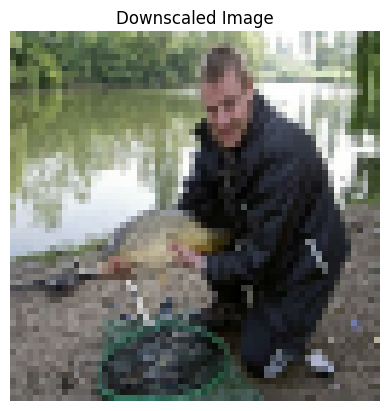

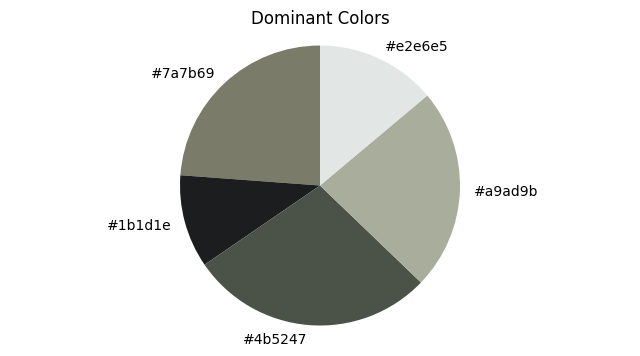

Color: #7a7b69, Percentage: 23.83%
Color: #1b1d1e, Percentage: 10.74%
Color: #4b5247, Percentage: 28.25%
Color: #a9ad9b, Percentage: 23.29%
Color: #e2e6e5, Percentage: 13.89%


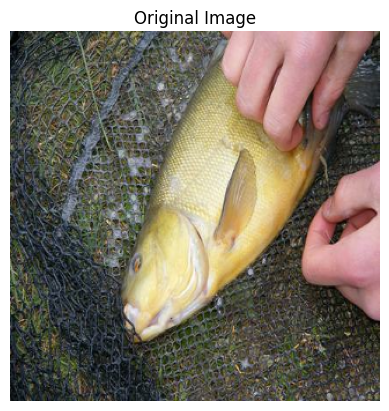

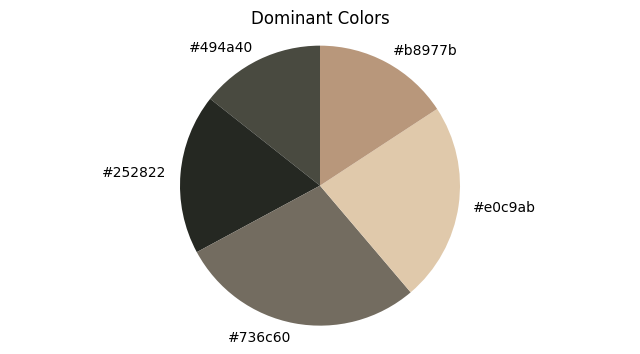

Color: #494a40, Percentage: 14.35%
Color: #252822, Percentage: 18.52%
Color: #736c60, Percentage: 28.33%
Color: #e0c9ab, Percentage: 23.01%
Color: #b8977b, Percentage: 15.77%


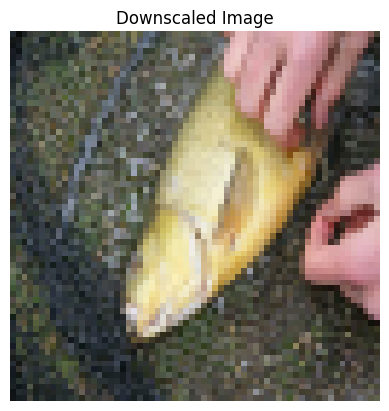

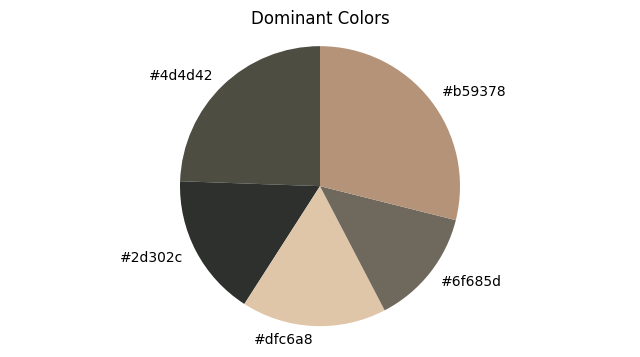

Color: #4d4d42, Percentage: 24.44%
Color: #2d302c, Percentage: 16.48%
Color: #dfc6a8, Percentage: 16.72%
Color: #6f685d, Percentage: 13.45%
Color: #b59378, Percentage: 28.91%


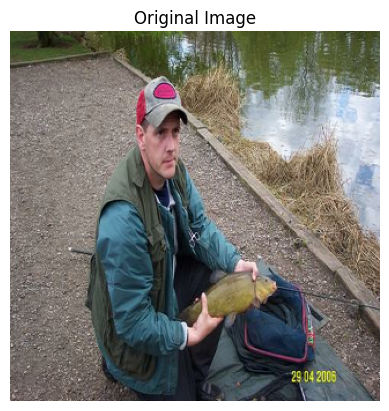

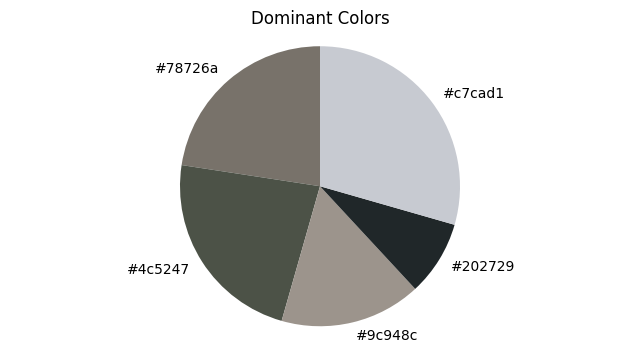

Color: #78726a, Percentage: 22.58%
Color: #4c5247, Percentage: 23.00%
Color: #9c948c, Percentage: 16.32%
Color: #202729, Percentage: 8.66%
Color: #c7cad1, Percentage: 29.44%


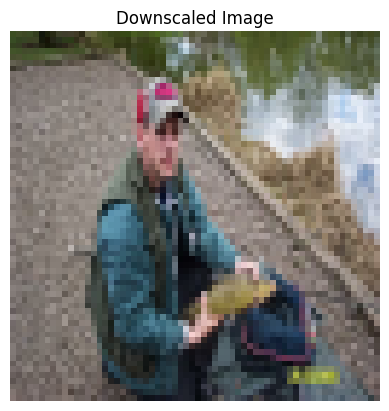

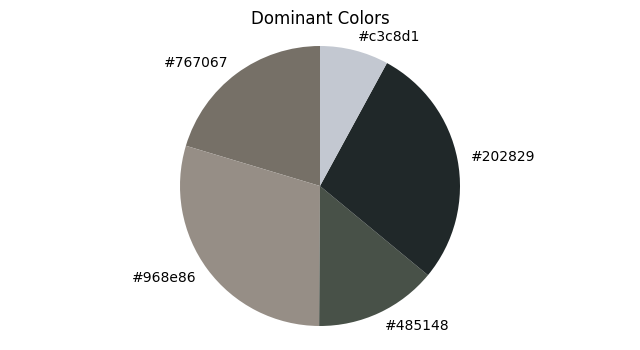

Color: #767067, Percentage: 20.36%
Color: #968e86, Percentage: 29.54%
Color: #485148, Percentage: 14.11%
Color: #202829, Percentage: 28.05%
Color: #c3c8d1, Percentage: 7.93%


In [34]:
for i in range(5):
    ori_img_dpid_sample = ori_img_dpid[i]
    dpid_downscaled_img_sample = dpid_downscaled_img[i]*255

    dominant_colors_ori, counts_ori = get_dominant_colors(ori_img_dpid_sample*255, k=5)
    dominant_colors_dwn, counts_dwn = get_dominant_colors(dpid_downscaled_img_sample*255, k=5)

    plt.imshow(ori_img_dpid_sample)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    plot_dominant_colors(dominant_colors_ori, counts_ori)

    total_pixels_ori = np.sum(counts_ori)
    percentage_colors_ori = (counts_ori / total_pixels_ori) * 100

    for color, percentage in zip(dominant_colors_ori, percentage_colors_ori):
        print(f'Color: #{color[0]:02x}{color[1]:02x}{color[2]:02x}, Percentage: {percentage:.2f}%')

    plt.imshow(dpid_downscaled_img_sample)
    plt.title('Downscaled Image')
    plt.axis('off')
    plt.show()

    plot_dominant_colors(dominant_colors_dwn, counts_dwn)

    total_pixels_dwn = np.sum(counts_dwn)
    percentage_colors_dwn = (counts_dwn / total_pixels_dwn) * 100

    for color, percentage in zip(dominant_colors_dwn, percentage_colors_dwn):
        print(f'Color: #{color[0]:02x}{color[1]:02x}{color[2]:02x}, Percentage: {percentage:.2f}%')

In [35]:
def plot_color_scatter(original, downscaled):
    orig_pixels = original.reshape(-1, 3)
    down_pixels = downscaled.reshape(-1, 3)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    sns.scatterplot(x=orig_pixels[:, 0], y=orig_pixels[:, 1], hue=orig_pixels[:, 2], palette="viridis", ax=axs[0])
    axs[0].set_title('Original Image Color Scatter')
    axs[0].set_xlabel('Channel 0')
    axs[0].set_ylabel('Channel 1')

    sns.scatterplot(x=down_pixels[:, 0], y=down_pixels[:, 1], hue=down_pixels[:, 2], palette="viridis", ax=axs[1])
    axs[1].set_title('Downscaled Image Color Scatter')
    axs[1].set_xlabel('Channel 0')
    axs[1].set_ylabel('Channel 1')

    plt.show()

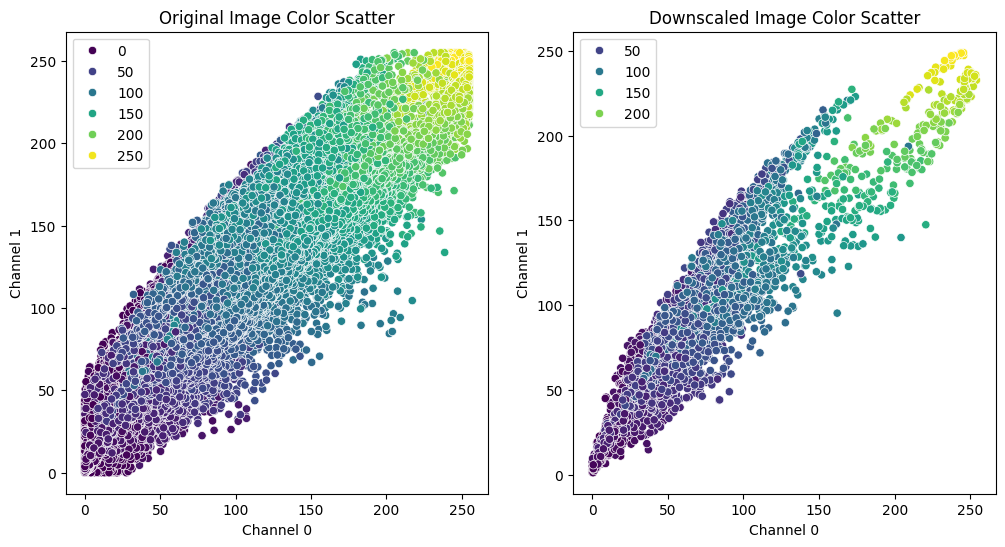

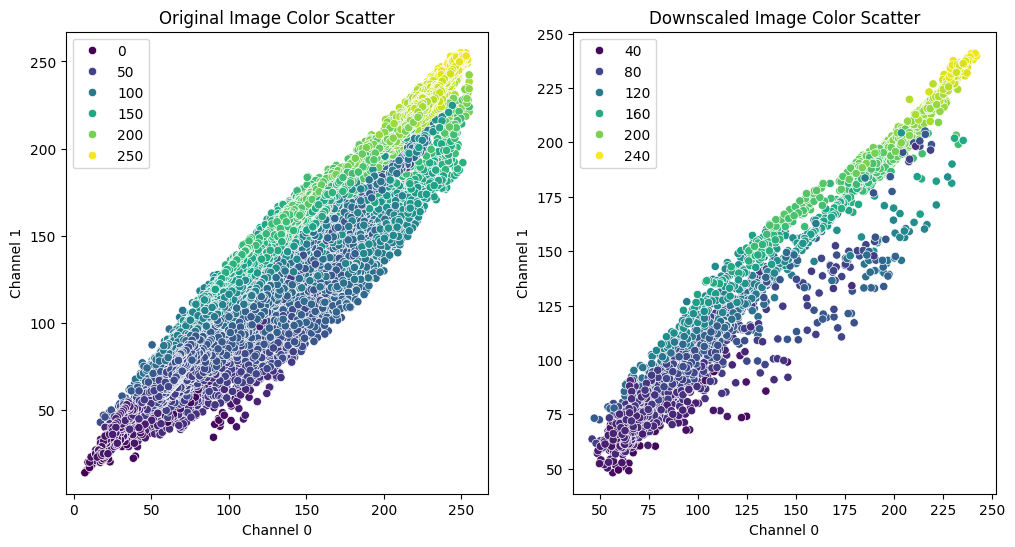

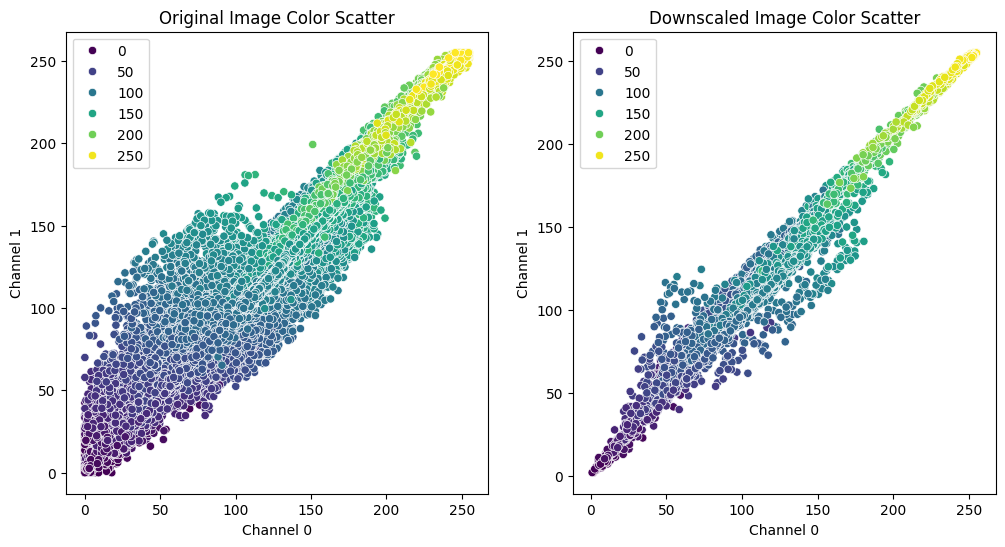

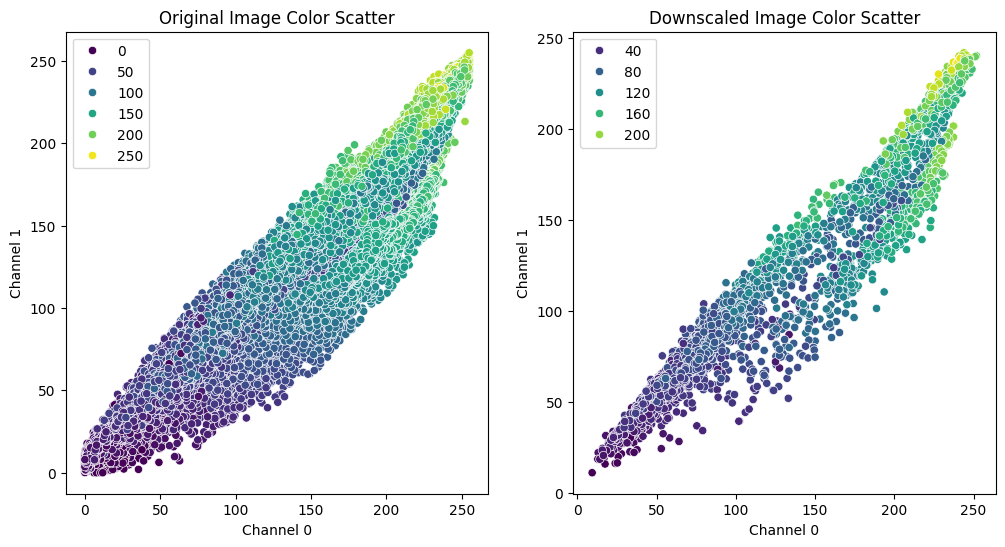

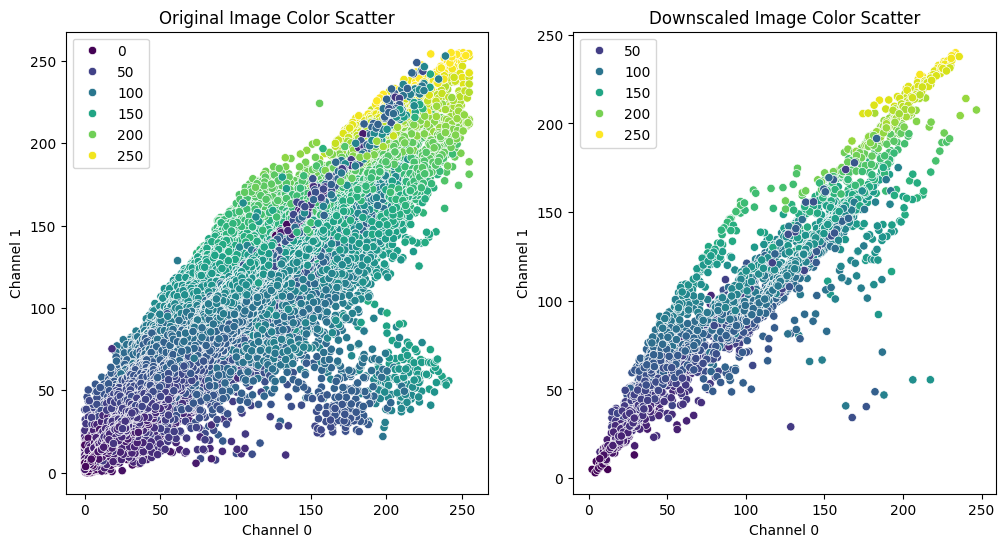

In [37]:
for i in range(5):
  ori_img_dpid_sample = ori_img_dpid[i]
  dpid_downscaled_img_sample = dpid_downscaled_img[i]*255
  plot_color_scatter(ori_img_dpid_sample*255, dpid_downscaled_img_sample*255)

In [40]:
from skimage.metrics import structural_similarity as ssim

In [45]:
def quantize_colors(image, n_colors=8):
    pixels = np.reshape(image, (-1, 3))
    kmeans = KMeans(n_clusters=n_colors).fit(pixels)
    new_colors = kmeans.cluster_centers_[kmeans.predict(pixels)]
    return new_colors.reshape(image.shape)

def compute_histogram(image):
    hist = cv2.calcHist([np.uint8(image)], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def compare_color_histograms(hist1, hist2):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)

def compare_images(original_image, downscaled_image):
    # Quantize colors
    orig_quantized = quantize_colors(original_image)
    down_quantized = quantize_colors(downscaled_image)

    # Compute color histograms
    orig_hist = compute_histogram(orig_quantized)
    down_hist = compute_histogram(down_quantized)

    # Compare histograms
    hist_similarity = compare_color_histograms(orig_hist, down_hist)
    hist_similarity /= np.sum(orig_hist)
    return hist_similarity

In [47]:
for i in range(n_data):
  ori_img_dpid_sample = ori_img_dpid[i]
  dpid_downscaled_img_sample = dpid_downscaled_img[i]*255
  # Compare images
  hist_similarity = compare_images(ori_img_dpid_sample*255, dpid_downscaled_img_sample*255)
  # Print results
  hist_sim_average = np.mean(hist_similarity)
print(f'Average Histogram Similarity: {hist_sim_average}')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Average Histogram Similarity: 0.8159674241527768
